In [3]:
from src.dataset.shelf import Shelf
from src.box_clustering import multiViewHumanBoxesClustering
from src.multiview_3d import solveMultiView3DHumanPoses
from src.bundle_adjustment import bundleAdjustmentWrapper
from src.plot_functions import *
from src.evaluate import *
import yaml

data_dir = './data/shelf'
config = yaml.safe_load(open('./config/panoptic.yml', 'r'))
dataset = Shelf(data_dir, config=config)
frame_id = 377
wrld_cam_id = 0


# --- Step 1: crop bounding box
boxcrop_dir = dataset.getSingleFrameMultiViewBoxes(frame_id)
box_reid_feat = dataset.getFrameReIDFeat(frame_id)

# # --- Step 2: cluster boxes using re-ID feature
boxfile_clusters = multiViewHumanBoxesClustering(
    box_reid_feat, size_max=dataset.num_cam,
    method='kmeans_ssc')

print(boxfile_clusters)

# --- Step 3: generate 2D-2D point correpondences
pts_corresp_dict, n_persons = dataset.genPtsCorrepFromBoxClus(
    boxfile_clusters)

# # --- Step 4: solve 3D human pose
Pts, BA_input, wrld_cam_name = solveMultiView3DHumanPoses(
    pts_corresp_dict, dataset.cam_params_dict, n_persons,
    Pts_prev=None, wrld_cam_id=wrld_cam_id)

# --- Step 5: bundle adjustement
Pts_BA, M2s_BA = bundleAdjustmentWrapper(
    BA_input, fix_cam_pose=False, wrld_cam_id=wrld_cam_id)


Perform clustering:

Method         Distance       Purity    RI        ARI       F_Score   
kmeans_ssc     cosine         1.000     1.000     nan       1.000     

{0: ['./data/shelf/box_crop/frame00000377/Camera0_0_65_219_776_436.jpg', './data/shelf/box_crop/frame00000377/Camera1_0_137_584_658_732.jpg', './data/shelf/box_crop/frame00000377/Camera2_0_105_655_598_742.jpg', './data/shelf/box_crop/frame00000377/Camera3_0_91_528_578_645.jpg', './data/shelf/box_crop/frame00000377/Camera4_0_34_514_499_651.jpg']}

Get 2D-2D correspondences:
Get pt correspondences of person 0.

Saved to:
"./data/shelf/box_crop/frame00000377/box_gen_pt_corr.pkl".


Solve 3D human and camera poses:
Done.
Ref cam id:0, name:0


Bundle adjustment:
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2547e+07                                    4.13e+07    
       1              2         1.7558e+06      1.08e+07       4.35e-01       7.97e+06  

Plot joints in shelf | camera Camera0 | frame 377.
Plot joints in shelf | camera Camera1 | frame 377.
Plot joints in shelf | camera Camera2 | frame 377.
Plot joints in shelf | camera Camera3 | frame 377.
Plot joints in shelf | camera Camera4 | frame 377.


(<Figure size 432x288 with 1 Axes>, <Axes3DSubplot:>)

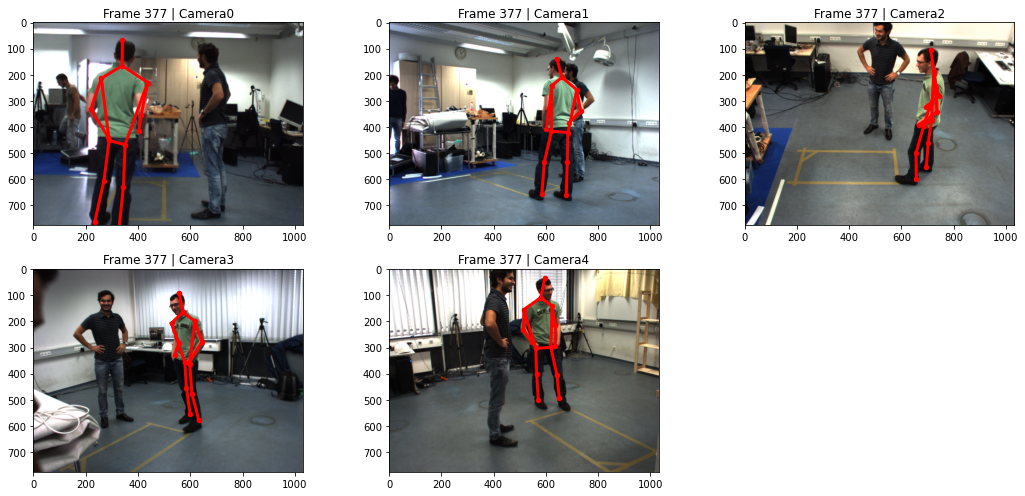

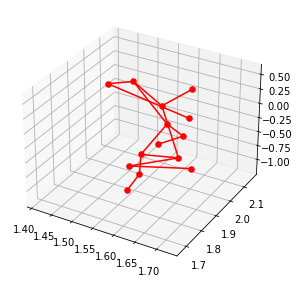

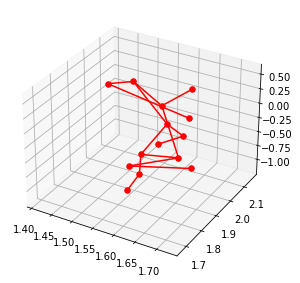

In [4]:
# --- Visualize 2D pose
plotSingleFrameMultiView2dJoints(
    dataset, frame_id, plot_joint_id=False, save_plot=True)

rot_x = 0
rot_z = 180
xlim, ylim, zlim = None, None, None

Pts_world = dataset.convertToWrldCoord(Pts, wrld_cam_name)
_, Pts_world, _, _ = dataset.alignEstAndGTCoords(frame_id, Pts, wrld_cam_name)
# Pts_world = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_world.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_world, n_persons, dataset.body_edges, plt_jnt_id=False, show_label=True,
                      xlim=xlim, ylim=ylim, zlim=zlim)

Pts_w_gt, Pts_w_est, _, scale = dataset.alignEstAndGTCoords(frame_id, Pts_BA, wrld_cam_name)
# Pts_w_est = b3dop.rotate3DPtsAroundZ(b3dop.rotate3DPtsAroundX(Pts_w_est.T, rot_x), rot_z).T
plotMulti3DHumanPoses(Pts_w_est, n_persons, dataset.body_edges, plt_jnt_id=False, show_label=True,
                      xlim=xlim, ylim=ylim, zlim=zlim)